# Exploring the MeasureUp DSB Training Data
The 2019 Data Science Bowl, sponsored nationally by my employer Booz Allen Hamilton, offers an opportunity to see how 3 - 5 year olds learn measurement-based skills with a PBS tablet app called MeasureUp. The competition's objective is to predict, based on their interactions with the app's games and activities, how kids will perform on skill assessments. 

## Skill Assessments
MeasureUp has 5 assessments for measurement skills. It would be helpful to know which skill each assessment is measuring. The best way to learn this would be to download the app and take each assessment. Sadly, I do not own a tablet, and the Android emulator in Android Studio cannot download the app from Play Store. This I am reduced to making a conjecture (below) about the mapping of skill to assessment based on the assessment titles. The results of prediction models should help refine this mapping as we proceed.
* Bird Measurer - length/height
* Cart Balancer - weight
* Cauldron Filler - capacity/displacement
* Chest Sorter - length/height
* Mushroom Sorter - weight

## Training Data
Let's take a look at the training data, which occupy over 3 GB on disk after unzipping.

In [1]:
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [2]:
path_to_train = os.path.join(os.getcwd(), "Documents/Data Science/DSB2019/data/train.csv")
df_train = pd.read_csv(path_to_train)
df_train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


### Fields
The competition's [data page](https://www.kaggle.com/c/data-science-bowl-2019/data) includes the following descriptions, which I quote below for the sake of convenience.

| Field | Description |
|:---|:---|
| **event_id** | Randomly generated unique identifier for the event type |
| **game_session** | Randomly generated unique identifier grouping events within a single game or video play session |
| **timestamp** | Client-generated datetime |
| **event_data** | Semi-structured JSON formatted string containing the events parameters. Default fields are: `event_count`, `event_code`, and `game_time`; otherwise fields are determined by the event type. |
| **installation_id** | Randomly generated unique identifier grouping game sessions within a single installed application instance |
| **event_count** | Incremental counter of events within a game session (offset at 1). Extracted from event_data. |
| **event_code** | Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data. |
| **game_time** | Time in milliseconds since the start of the game session. Extracted from event_data. |
| **title** | Title of the game or video |
| **type** | Media type of the game or video. Possible values are: **'Game'**, **'Assessment'**, **'Activity'**, **'Clip'**. |
| **world** | The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: **'NONE'** (at the app's start screen), **'TREETOPCITY'** (Length/Height), **'MAGMAPEAK'** (Capacity/Displacement), **'CRYSTALCAVES'** (Weight). |

The remainder of this EDA notebook examines how these fields might be used in feature engineering and prediction algorithm development.

#### 'installation_id' and 'game_session'
Assuming that each unique `installation_id` represents usage by a single child, we can use the number of `game session` records per `installation_id` to categorize the extent to which a child uses the app. We might choose to engineer a usage categorization feature (e.g., 'light', 'medium', or 'heavy' use), or even use the raw number of game sessions per installation as a numeric feature. Let's use the Pandas DataFrame `describe()` method to start our analysis of `game_session` data.

In [74]:
df_by_installation = df_train[['installation_id','game_session']]
session_counts_per_installation = df_by_installation.groupby('installation_id').count()
session_counts_per_installation.describe()

,game_session
count,17000.000000
mean,667.120118
std,1658.552786
min,1.000000
25%,7.000000
50%,157.000000
75%,609.000000
max,58988.000000


The training data represent 17,000 installations of the MeasureUp app. Average usage over the course of the 120-day study period is about 5 game sessions per day. However, the variance is quite large, ranging from tossed aside after a single session to almost 500 sessions per day. The maximum of ~500 sessions per day almost certainly represents a shared tablet in a school or childcare setting, and suggests the possibility that installations with hundreds (and perhaps down to dozens) of sessions per day represent are shared among many children. In turn, installation sharing would probably inhibit the ability to use previous game sessions to predict assessment outcomes.

Let's visualize the distribution of game sessions per installation.

Text(0.5, 1.0, 'How many devices have how many sessions?')

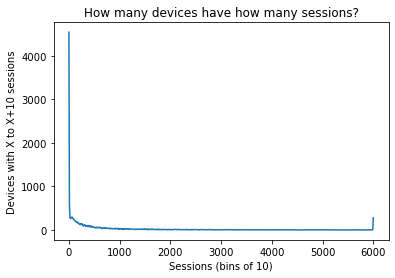

In [75]:
bin_counts = np.bincount(session_counts_per_installation['game_session'])
hist_10s = [np.sum(bin_counts[i:i+10]) for i in range(0, 6000, 10)]
hist_10s.append(np.sum(bin_counts[6010:]))
y = hist_10s
x = [i for i in range(0, 6010, 10)]
plt.plot(x, y)
plt.xlabel("Sessions (bins of 10)")
plt.ylabel("Devices with X to X+10 sessions")
plt.title("How many devices have how many sessions?")

The number of game sessions per installation resembles a power law distribution with a very long right tail. Let's get a closer look at the trends in the most common scenario, light usage.

Text(0.5, 0, 'Sessions')

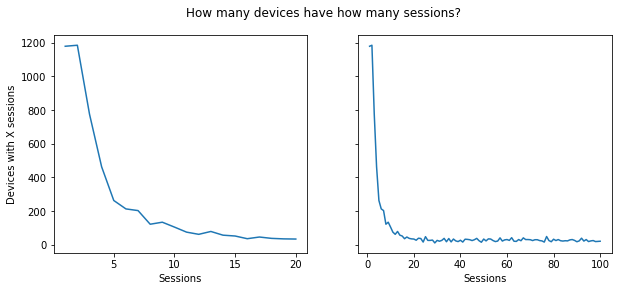

In [78]:
fig = plt.figure(figsize = (10, 4))
fig.suptitle("How many devices have how many sessions?")
axes_array = fig.subplots(1, 2, sharey = True)

# first subplot 1 - 20
y = bin_counts[1:21]
x = [i for i in range(1, 21)]
axes_array[0].plot(x, y)
axes_array[0].set_xlabel("Sessions")
axes_array[0].set_ylabel("Devices with X sessions")

# first subplot 1 - 100
y = bin_counts[1:101]
x = [i for i in range(1, 101)]
axes_array[1].plot(x, y)
axes_array[1].set_xlabel("Sessions")

Roughly 14% of the installations report only 1 or 2 game sessions--almost no activity. After game session frequency declines down to roughly 20 per installation, it stabilizes in the range 20 - 100.

In [ ]:
# TODO - Does the test set include multi-assessment installations?

#### 'world' and 'type'
Understanding how often children visit the various "worlds" happens us understand which measurement skills are getting the most attention. The data show that MAGMAPEAK is the most popular world. CRYSTALCAVES and TREETOPCITY are not too far back, and approximately equal in popularity. Observations in the NONE category are so infrequent as to suggest poor correlation with assessment performance.

The "type" of interaction a child has with the app could very well influence their assessment performance. The kids are truly members of the species *Homo ludens*: games top the popularity chart. On the flip side, clips are so infrequent as to be unlikely to help predict assessment performance.

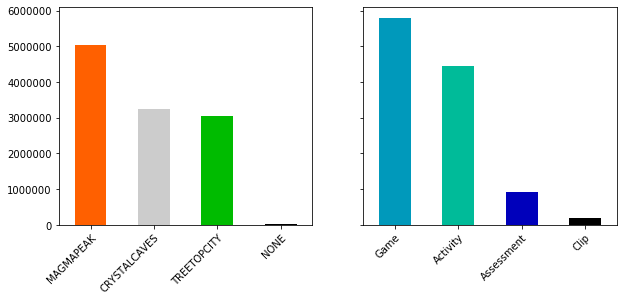

In [77]:
world_counts = df_train['world'].value_counts()
type_counts = df_train['type'].value_counts()
fig = plt.figure(figsize = (10, 4))
axes_array = fig.subplots(1, 2, sharey = True)
world_counts.plot.bar(ax = axes_array[0], 
                      color = ['#FF6000', '#CCCCCC', '#00BB00', '#000000'])
type_counts.plot.bar(ax = axes_array[1],
                     color = ['#0099BB', '#00BB99', '#0000BB', '#000000'])
for ax in axes_array:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#### 'event_code': Early vs. Late
Events that tend to happen early in a `game_session` would tend to have lower `event_count` values than those that occur later. We can order the event codes from earliest to latest by sorting on the mean `event_count` per `event_code`. As expected, the session start event code (2000) is the earliest.

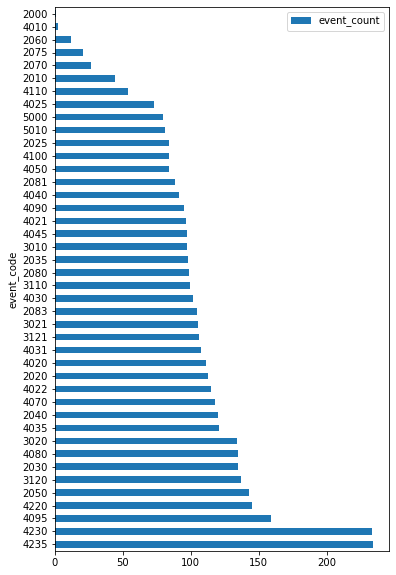

In [114]:
event_codes_by_session = df_train[['event_code', 'event_count']]
event_counts = event_codes_by_session.groupby('event_code').mean()
sorted_counts = event_counts.sort_values('event_count', ascending = False)
axes = sorted_counts.plot.barh(y = 'event_count')
axes.figure.set_figheight(10)

#### 'event_data': Which args are most frequent?
Recall that each `event_id` has a corresponding schema that describes the JSON data in the `event_data`field. The event data associated with the event IDs most highly correlated with assessment performance will no doubt need to be mined in detail to train the most accurate prediction models. As a first approximation, though, we can simply target the `event_data` arguments that are reasonably frequent (frequency > 25%) for our earliest feature engineering.

As the competition's [data page](https://www.kaggle.com/c/data-science-bowl-2019/data) notes, the `game_time`, `event_count`, and `event_code` arguments are present in the `event_data` for all non-clip events. Our analysis below shows that all events of type 'Game' always have a `round` argument, as well. 

A heat map of arguments by `event_id` is quite sparse, demonstrating that most arguments are very infrequently shared among event IDs. To discover the reasonably frequent arguments, the analysis concludes with graphs of arguments having frequency greater than 25% for non-clip events.

In [51]:
path_to_specs = os.path.join(os.getcwd(), "Documents/Data Science/DSB2019/data/specs.csv")
df_specs = pd.read_csv(path_to_specs, index_col = 0)
idx = df_specs.index
template = pd.Series([0 for _ in range(len(idx))], index = idx)
heat_map_dict = {}
for key, serialized_arg_list in df_specs['args'].iteritems():
    arg_list = json.loads(serialized_arg_list)
    for arg_dict in arg_list:
        arg_name = arg_dict['name']
        if arg_name not in heat_map_dict:
            heat_map_dict[arg_name] = template.copy()
        heat_map_dict[arg_name][key] = 1.0

heat_map = pd.DataFrame(heat_map_dict)
            

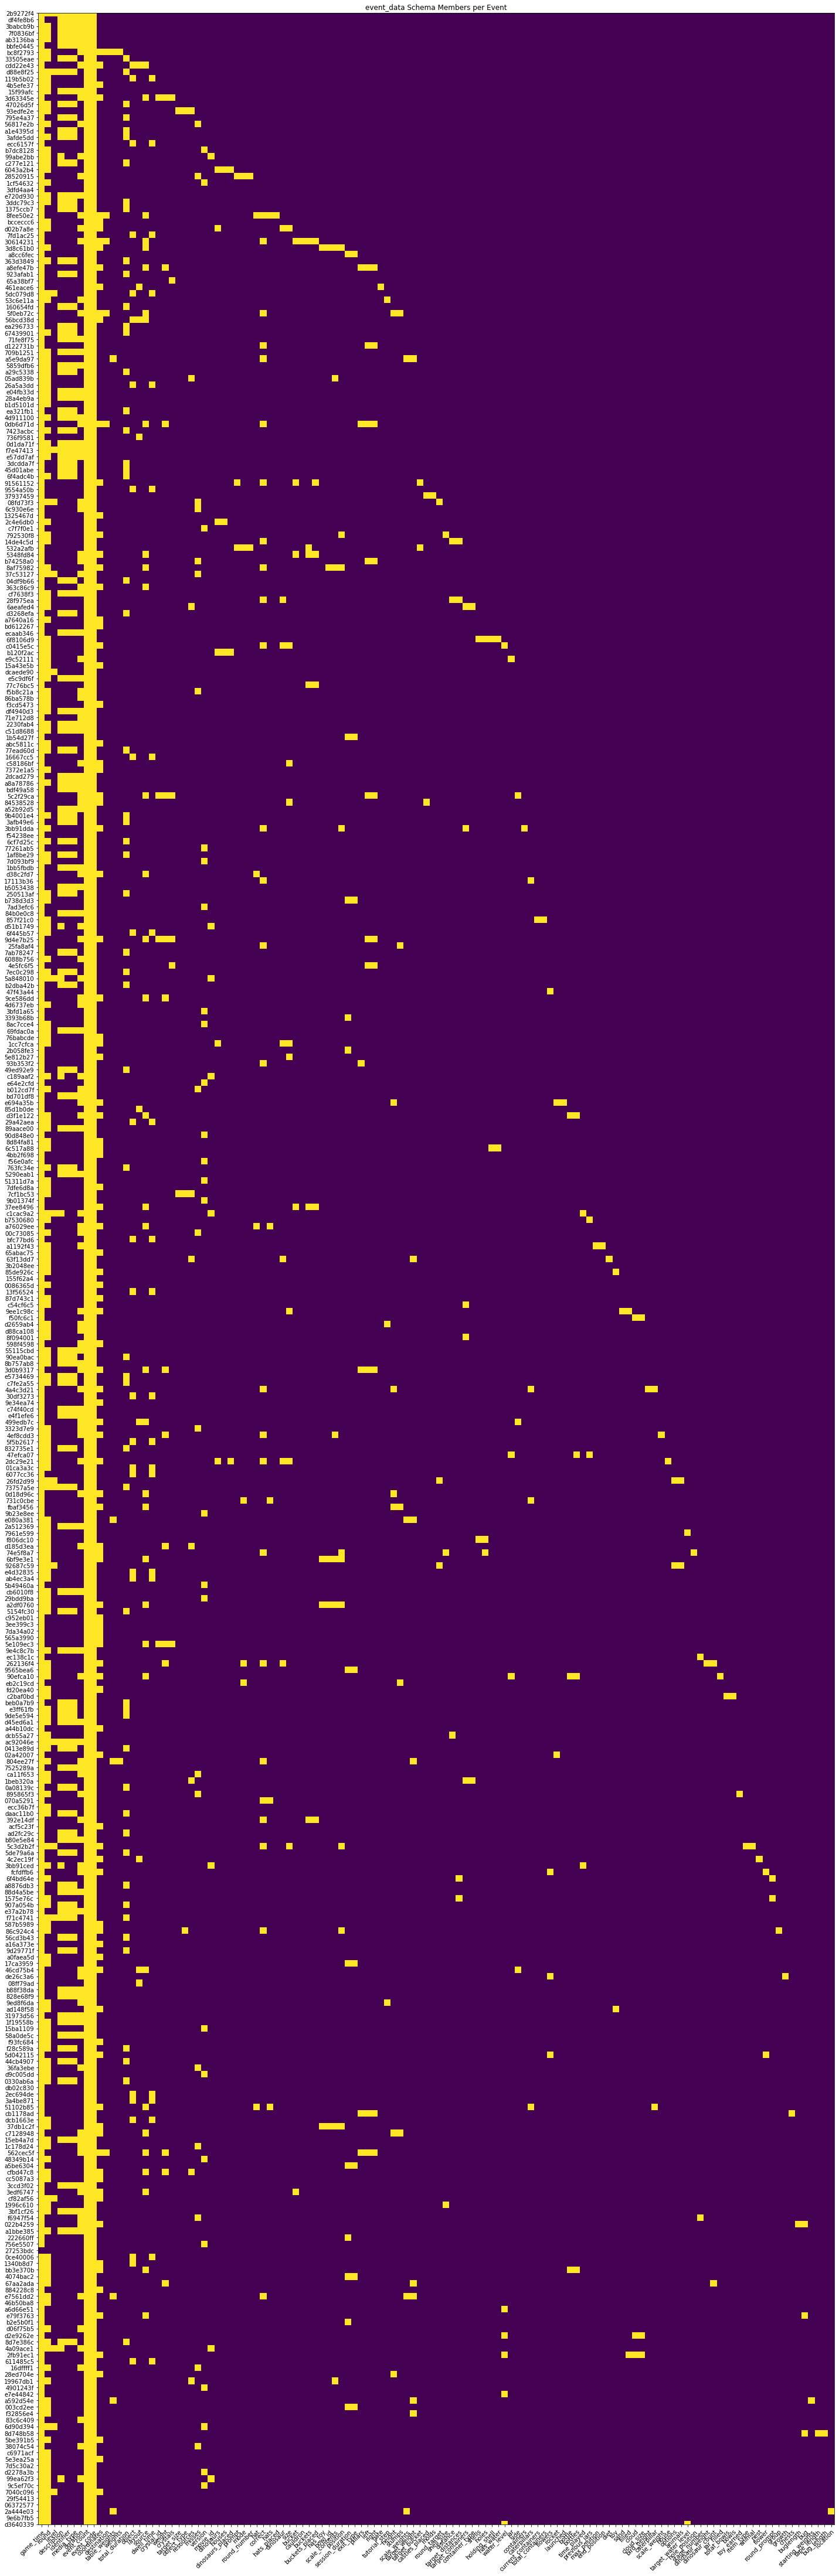

In [56]:
fig = plt.figure(figsize = (20, 80))
ax = fig.subplots()
im = ax.imshow(heat_map)

# show all ticks
ax.set_xticks(np.arange(len(heat_map.columns)))
ax.set_yticks(np.arange(len(heat_map)))

# label the ticks
ax.set_xticklabels(heat_map.columns)
ax.set_yticklabels(heat_map.index)

# Rotate the x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("event_data Schema Members per Event")
fig.tight_layout()



Common event_data args for type Game: ['game_time', 'round', 'event_count', 'event_code']
Common event_data args for type Activity: ['game_time', 'event_count', 'event_code']
Common event_data args for type Assessment: ['game_time', 'event_count', 'event_code']


Text(0.5, 0.98, "Most frequent 'event_data' arguments for GAME, ACTIVITY, and ASSESSMENT")

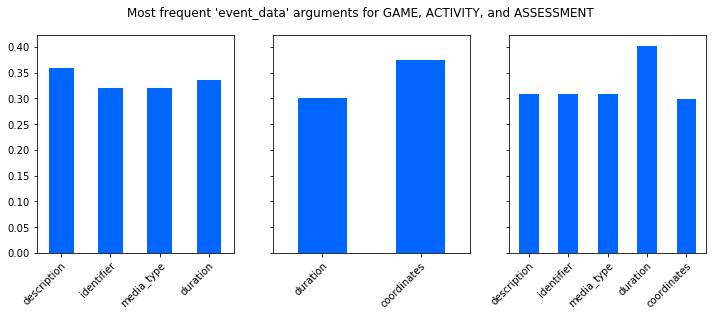

In [98]:
# Which args are most frequent?
#  per type
df_event_type = df_train[['event_id', 'type']]

def analyze_type(t):
    type_common_args = []
    frequency = []
    args = []
    event_ids = df_event_type['event_id'][df_event_type['type'] == t].unique()
    mask = np.array([idx in event_ids for idx in heat_map.index])
    type_heat_map = heat_map[mask]
    for col in type_heat_map.columns:
        if all(type_heat_map[col] == 1):
            type_common_args.append(col)
        arg_frequency = np.sum(type_heat_map[col])/len(type_heat_map[col])
        if 1.0 > arg_frequency > 0.25:
            args.append(col)
            frequency.append(arg_frequency)
    print(f"Common event_data args for type {t}: {type_common_args}")
    return pd.DataFrame(frequency, index = args)

fig = plt.figure(figsize = (12, 4))
axes_array = fig.subplots(1, 3, sharey = True)
    
for i, t in enumerate(['Game', 'Activity', 'Assessment']):
    df = analyze_type(t)
    df.plot.bar(ax = axes_array[i], 
                color = ['#0066FF' for _ in range(len(df))], 
                legend = None)
    
for ax in axes_array:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.suptitle("Most frequent 'event_data' arguments for GAME, ACTIVITY, and ASSESSMENT")
